In [20]:
import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

from jcopml.pipeline import num_pipe, cat_pipe
from jcopml.utils import save_model, load_model
from jcopml.plot import plot_missing_value
from jcopml.feature_importance import mean_score_decrease

from luwiji.logistic_regression import illustration

In [21]:
df = pd.read_csv('https://raw.githubusercontent.com/amongnikol/belajaraDataScienceJCOp/refs/heads/main/course3-regresi%26klasifikasiLanjutan/data/loan_data.csv')
df.head()

,person_age,person_gender,person_education,person_income,person_emp_exp,person_home_ownership,loan_amnt,loan_intent,loan_int_rate,loan_percent_income,cb_person_cred_hist_length,credit_score,previous_loan_defaults_on_file,loan_status
0,22.0,female,Master,71948.0,0,RENT,35000.0,PERSONAL,16.02,0.49,3.0,561,No,1
1,21.0,female,High School,12282.0,0,OWN,1000.0,EDUCATION,11.14,0.08,2.0,504,Yes,0
2,25.0,female,High School,12438.0,3,MORTGAGE,5500.0,MEDICAL,12.87,0.44,3.0,635,No,1
3,23.0,female,Bachelor,79753.0,0,RENT,35000.0,MEDICAL,15.23,0.44,2.0,675,No,1
4,24.0,male,Master,66135.0,1,RENT,35000.0,MEDICAL,14.27,0.53,4.0,586,No,1


In [22]:
df.cb_person_cred_hist_length.value_counts()

4.0     8653
3.0     8312
2.0     6537
5.0     3082
6.0     2966
7.0     2889
8.0     2800
9.0     2685
10.0    2457
12.0     715
11.0     712
14.0     644
13.0     625
15.0     557
16.0     542
17.0     469
20.0      43
24.0      34
18.0      34
22.0      32
28.0      29
19.0      29
23.0      26
21.0      24
25.0      23
27.0      23
30.0      23
26.0      20
29.0      15
Name: cb_person_cred_hist_length, dtype: int64

In [23]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 45000 entries, 0 to 44999
Data columns (total 14 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   person_age                      45000 non-null  float64
 1   person_gender                   45000 non-null  object 
 2   person_education                45000 non-null  object 
 3   person_income                   45000 non-null  float64
 4   person_emp_exp                  45000 non-null  int64  
 5   person_home_ownership           45000 non-null  object 
 6   loan_amnt                       45000 non-null  float64
 7   loan_intent                     45000 non-null  object 
 8   loan_int_rate                   45000 non-null  float64
 9   loan_percent_income             45000 non-null  float64
 10  cb_person_cred_hist_length      45000 non-null  float64
 11  credit_score                    45000 non-null  int64  
 12  previous_loan_defaults_on_file  

In [ ]:
from jcopml.plot import plot_association_matrix

plot_association_matrix(df, 'loan_status', categoric_col=['person_gender', 'person_education','person_home_ownership', 'loan_intent','previous_loan_defaults_on_file'])

interactive(children=(ToggleButtons(description='method', options=("Cramer's V", 'Proficiency U(X|Y)', 'Profic…

In [30]:
corr = df.drop(columns=['person_gender', 'person_education','person_home_ownership', 'loan_intent','previous_loan_defaults_on_file','loan_status'])
corr.columns

Index(['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score'],
      dtype='object')

In [31]:
from jcopml.plot import plot_correlation_matrix

plot_correlation_matrix(df, 'loan_status', numeric_col = ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score'])

interactive(children=(ToggleButtons(description='method', options=('spearman', 'kendall', 'pearson', 'pearson_…

In [35]:
df.loan_status.value_counts()

0    35000
1    10000
Name: loan_status, dtype: int64

In [25]:
x = df.drop(columns='loan_status')
y = df.loan_status

# stratify untuk membagi target ke test dan training seimbang# training
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, stratify=y, random_state=42)
x_train.shape, x_test.shape, y_train.shape, y_test.shape

((36000, 13), (9000, 13), (36000,), (9000,))

In [32]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from jcopml.tuning import grid_search_params as gsp
from jcopml.tuning.space import Integer, Real

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform='yeo-johnson'), ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score']),
    ('categoric', cat_pipe(encoder='onehot'), ['person_gender', 'person_education','person_home_ownership', 'loan_intent','previous_loan_defaults_on_file'])
])

# optimizernya tidak pakai gradient descent biasa melainkan menggunakan lbfgs
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

# cv = cross validation
model = GridSearchCV(pipeline, gsp.logreg_params, scoring='f1', cv=3, n_jobs=-1, verbose=1)
model.fit(x_train, y_train)

print(model.best_params_)
print(model.score(x_train, y_train), model.best_score_, model.score(x_test, y_test))

Fitting 3 folds for each of 14 candidates, totalling 42 fits


c:\Users\akmal\anaconda3\envs\jcopml\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__C': 1.0, 'algo__fit_intercept': False}
0.7767738674417136 0.7764200998430374 0.7882472137791288


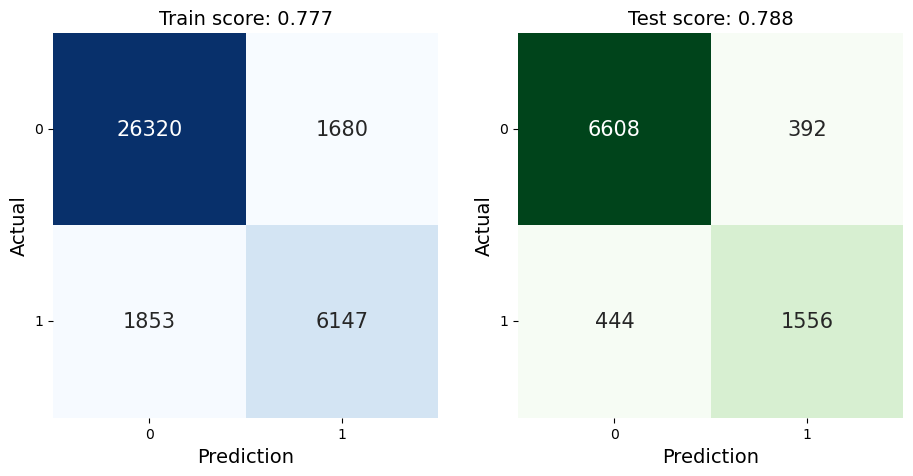

In [37]:
from jcopml.plot import plot_confusion_matrix

plot_confusion_matrix(x_train,y_train,x_test,y_test, model)

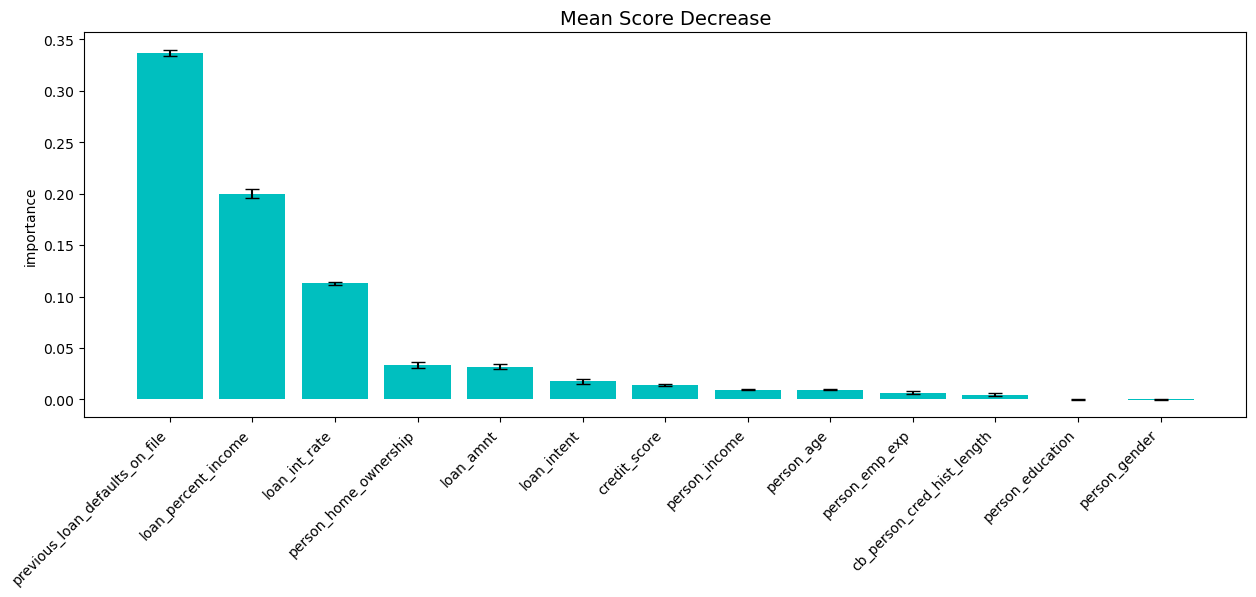

In [38]:
df_imp = mean_score_decrease(x_train, y_train, model, plot=True)

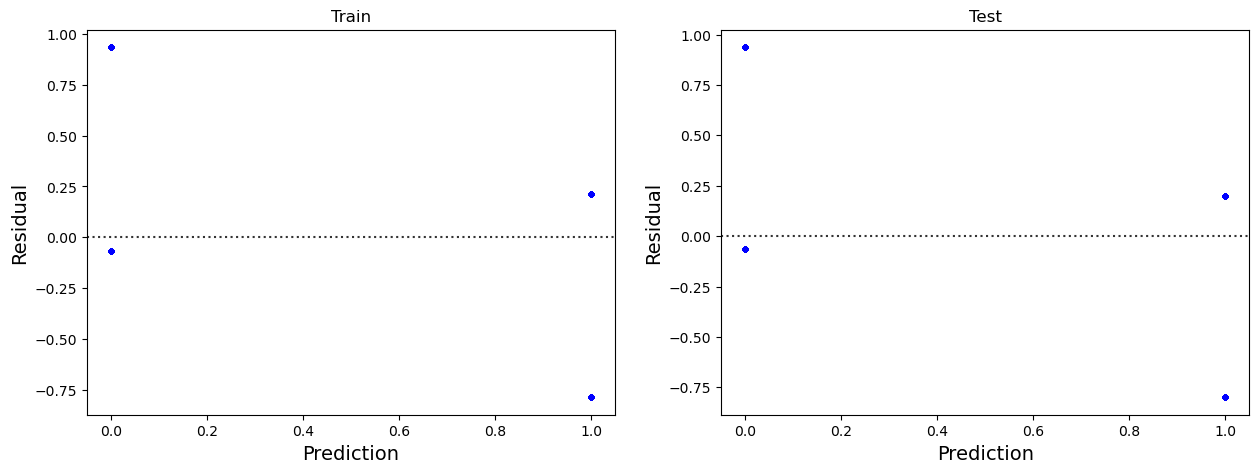

In [39]:
from jcopml.plot import plot_residual

plot_residual(x_train, y_train, x_test, y_test, model)

In [42]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform='yeo-johnson'), ['loan_amnt','credit_score', 'loan_int_rate', 'loan_percent_income']),
    ('categoric', cat_pipe(encoder='onehot'), ['person_home_ownership', 'loan_intent','previous_loan_defaults_on_file'])
])

# optimizernya tidak pakai gradient descent biasa melainkan menggunakan lbfgs
pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', LogisticRegression(solver='lbfgs', n_jobs=-1, random_state=42))
])

# cv = cross validation
model = GridSearchCV(pipeline, gsp.logreg_params, scoring='f1', cv=3, n_jobs=-1, verbose=1)
model.fit(x_train, y_train)

print(model.best_params_)
print(model.score(x_train, y_train), model.best_score_, model.score(x_test, y_test))

Fitting 3 folds for each of 14 candidates, totalling 42 fits


c:\Users\akmal\anaconda3\envs\jcopml\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__C': 100.0, 'algo__fit_intercept': False}
0.7787945724203219 0.7794037809387531 0.7931121802988099


In [44]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from jcopml.tuning import grid_search_params as gsp
from jcopml.tuning import random_search_params as rsp

In [ ]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(poly=2, transform='yeo-johnson'), ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score']),
    ('categoric', cat_pipe(encoder='onehot'), ['person_gender', 'person_education','person_home_ownership', 'loan_intent','previous_loan_defaults_on_file'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

# cv = cross validation
model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=3,n_iter=50, n_jobs=-1, verbose=1)
model.fit(x_train, y_train)

print(model.best_params_)
print(model.score(x_train, y_train), model.best_score_, model.score(x_test, y_test))

Fitting 3 folds for each of 10 candidates, totalling 30 fits


c:\Users\akmal\anaconda3\envs\jcopml\lib\site-packages\sklearn\preprocessing\_data.py:3253: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


{'algo__max_depth': 57, 'algo__max_features': 0.6308271314444164, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 147}
1.0 0.9249166666666667 0.9277777777777778


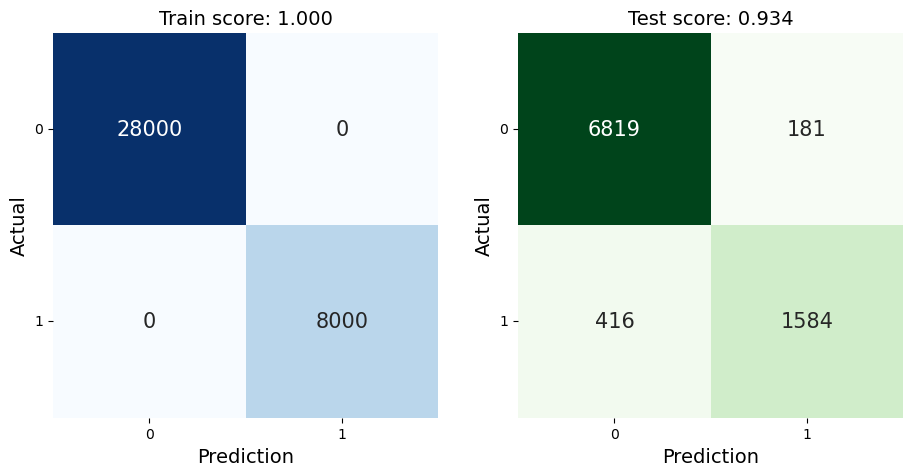

In [61]:
from jcopml.plot import plot_confusion_matrix

plot_confusion_matrix(x_train,y_train,x_test,y_test, model)

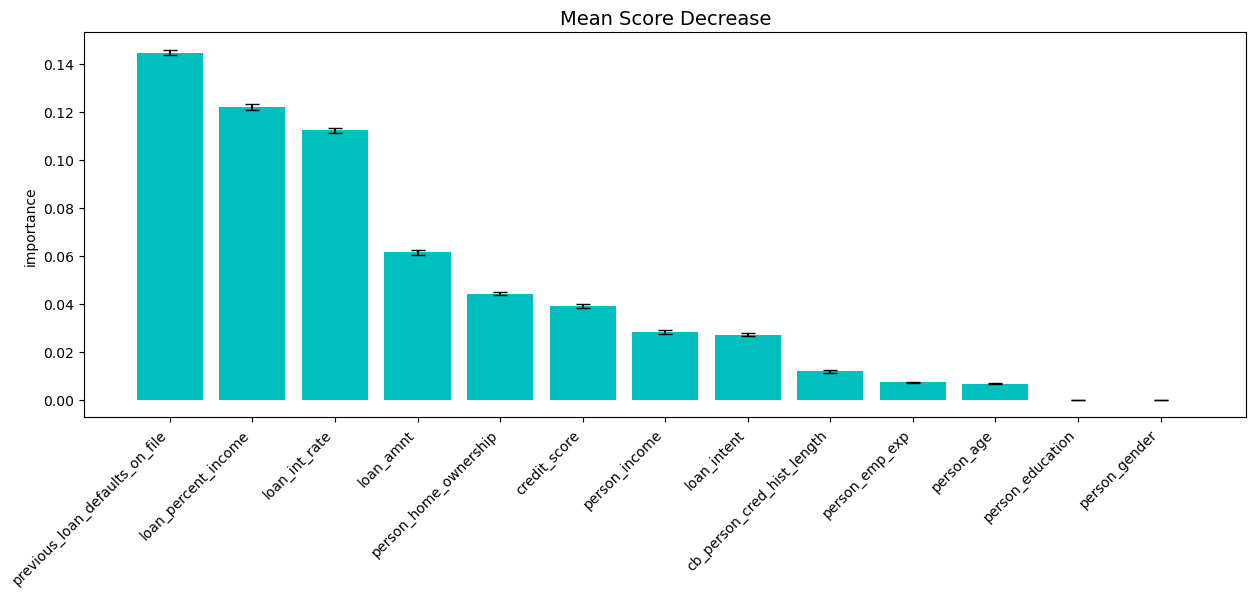

In [55]:
df_imp = mean_score_decrease(x_train, y_train, model, plot=True)

In [62]:
preprocessor = ColumnTransformer([
    ('numeric', num_pipe(), ['person_age', 'person_income', 'person_emp_exp', 'loan_amnt',
       'loan_int_rate', 'loan_percent_income', 'cb_person_cred_hist_length',
       'credit_score']),
    ('categoric', cat_pipe(encoder='onehot'), ['person_home_ownership', 'loan_intent','previous_loan_defaults_on_file'])
])

pipeline = Pipeline([
    ('prep', preprocessor),
    ('algo', RandomForestClassifier(n_jobs=-1, random_state=42))
])

# cv = cross validation
model = RandomizedSearchCV(pipeline, rsp.rf_params, cv=5,n_iter=50, n_jobs=-1, verbose=1)
model.fit(x_train, y_train)

print(model.best_params_)
print(model.score(x_train, y_train), model.best_score_, model.score(x_test, y_test))

Fitting 5 folds for each of 50 candidates, totalling 250 fits
{'algo__max_depth': 65, 'algo__max_features': 0.4765580528907424, 'algo__min_samples_leaf': 1, 'algo__n_estimators': 195}
1.0 0.9303888888888888 0.9338888888888889
